In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_data(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats = 4
    dat = np.reshape(dat,[n/nstats,nstats])
    Prod = dat[:,0]
    Pi11 = dat[:,1]
    Pi22 = dat[:,2]
    Pi12 = dat[:,3]
    return Prod,Pi11,Pi22,Pi12

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*pstrain*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_pstrain_0001.dat', 'shearlayer_pstrain_0002.dat', 'shearlayer_pstrain_0003.dat', 'shearlayer_pstrain_0004.dat', 'shearlayer_pstrain_0005.dat', 'shearlayer_pstrain_0006.dat', 'shearlayer_pstrain_0007.dat', 'shearlayer_pstrain_0008.dat', 'shearlayer_pstrain_0009.dat', 'shearlayer_pstrain_0010.dat', 'shearlayer_pstrain_0011.dat', 'shearlayer_pstrain_0012.dat', 'shearlayer_pstrain_0013.dat']


(2.0, 1.0)


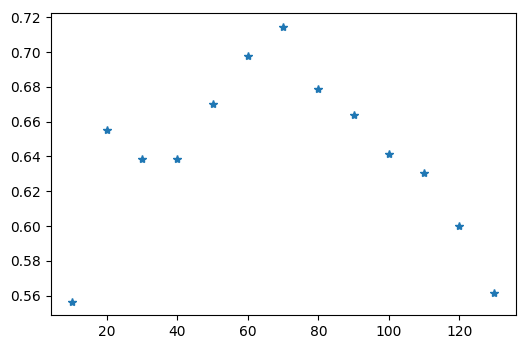

In [28]:
# Integrated profiles

def integrate_Pij(directory,flist,name):
    mat = np.zeros([len(flist),2])
    for i,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]

        Prod,Pi11,Pi22,Pi12 = get_data(fname)
        if name=='prod': dat=-Prod
        elif name=='pi11': dat=Pi11
        elif name=='pi22': dat=Pi22
        elif name=='pi12': dat=Pi12
    
        # Do some windowing
#         try:
#             windowed = window_field(directory+'/shearlayer_',y[None,:,None],y,inp.du,tID,dat[None,:,None])
#         except: print('{}: Write utilde for {}'.format(inp.Mc,tID)); 
        #plt.plot(np.squeeze(dat),label=time)
        windowed=dat
        
        # integrate
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(windowed))/dtheta
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

        
fig = plt.figure(dpi=100)
pdat = integrate_Pij(directory,flist[:],name='prod')
pidat = integrate_Pij(directory,flist[:],name='pi12')
t = pdat[:,0]
f = pidat[:,1]/pdat[:,1]
plt.plot(t,f,'*')
# plt.ylim([-10,10])
print(inp.Mc,inp.rr)

0.2:[-0.615033762382,0.0141369348503],
0.4:[-0.675129133043,0.0302659469256],
0.8:[-0.62154436525,0.0329651638112],
1.2:[-0.650032769077,0.027087936852],
1.6:[-0.64877260317,0.0258476740955],
2.0:[-0.661763500071,0.0345782292114],
Done


(0, 200)

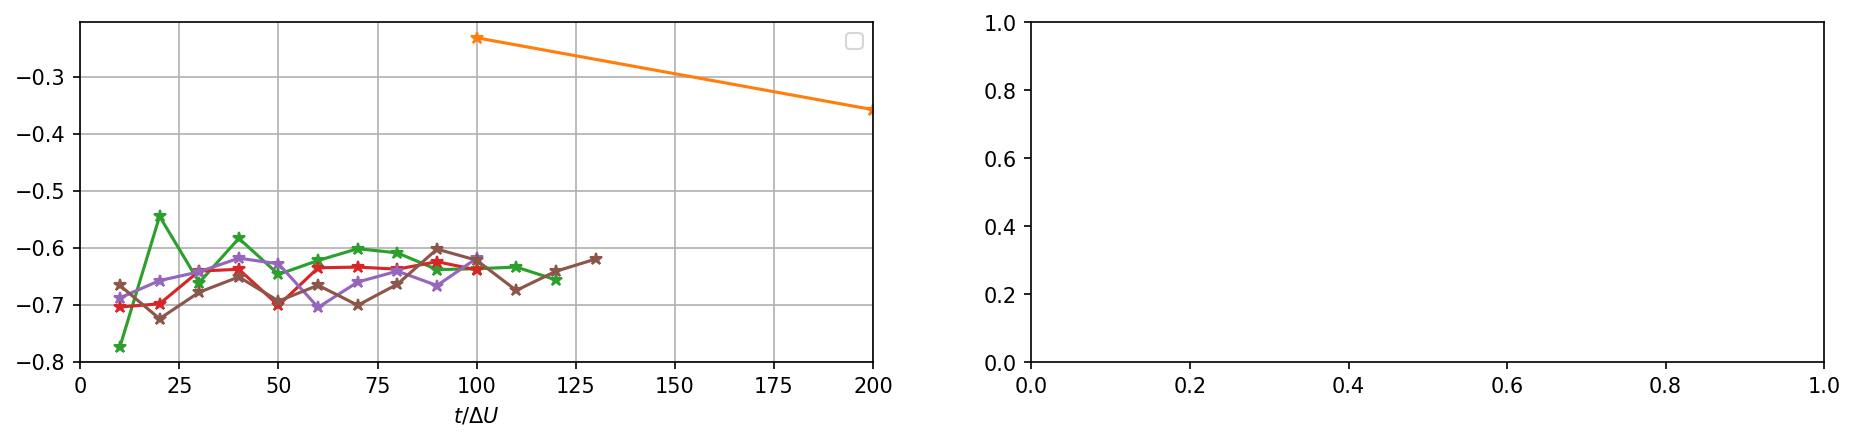

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [63]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*pstrain*")
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    # Plot Rij
    fig = plt.figure(dpi=100)
    dat1 = integrate_Pij(directory,flist[:],name='prod')
    dat2 = integrate_Pij(directory,flist[:],name='pi11')
    t = dat1[:,0]
    f = dat2[:,1]/dat1[:,1]
    ax[0].plot(t,f,'-*')
    
    if inp.Mc>0.4: 
        idx = 1
        print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    elif inp.Mc==0.2:
        idx = 10
        print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    elif inp.Mc==0.4:
        idx = 10
        print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:-4]),np.std(f[idx:-4])))
    
print('Done')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel(r'$t/\Delta U$')
# ax[0].set_xlim([0,1000])
ax[0].set_xlim([0,200])
# ax[0].set_ylim([-10,10])

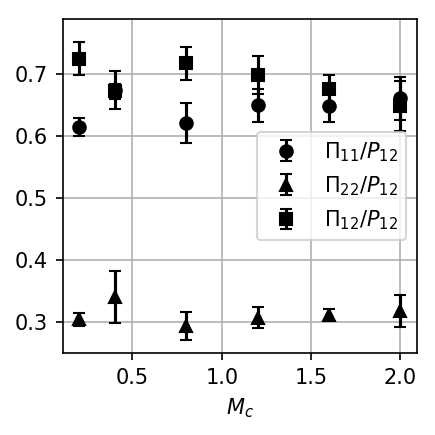

In [72]:
pi11_p12 = {
0.2:[0.615033762382,0.0141369348503],
0.4:[0.675129133043,0.0302659469256],
0.8:[0.62154436525,0.0329651638112],
1.2:[0.650032769077,0.027087936852],
1.6:[0.64877260317,0.0258476740955],
2.0:[0.661763500071,0.0345782292114],
}
pi22_p12 = {
0.2:[0.30551846508,0.0105104332176],
0.4:[0.340997329264,0.0422464857978],
0.8:[0.294776012151,0.0227642852489],
1.2:[0.307827535855,0.0173370530452],
1.6:[0.312475237168,0.00872304626439],
2.0:[0.318184499481,0.025456423217],
}
pi12_p12 = { #Pi_12 / production
0.2:[0.724999867545,0.026802288315],
0.4:[0.672332539737,0.0123282107527],
0.8:[0.717475991041,0.0261283724852],
1.2:[0.698764297412,0.0310105785375],
1.6:[0.675618121709,0.0239162044815],
2.0:[0.649151935366,0.0397246854268],
}
pi22_pi11 = { # makepositive
0.2:[0.496913261029,0.0179001043242],
0.4:[0.503251510084,0.0426366233015],
0.8:[0.473851749558,0.0198266098335],
1.2:[0.473705651432,0.022305873577],
1.6:[0.482356783065,0.0223054363827],
2.0:[0.480726126309,0.0270159003313],
}
pi11_p12_Freund = {
0.10: [0.9891 ,0 ],
0.21: [0.9934 ,0 ],
0.41: [1.0792 ,0 ],
0.59: [1.1067 ,0 ],
0.79: [1.1130 ,0 ],
0.99: [1.0655 ,0 ],
1.29: [1.0107 ,0 ],
1.54: [0.8741 ,0 ],
1.80: [0.8919 ,0 ],
}
pi22_p12_Freund = {
0.10: [ 0.42105454655710867 ,0 ],
0.21: [ 0.4174039598556745  ,0 ],
0.41: [0.42304357054061437  ,0 ],
0.59: [ 0.4416542858009157  ,0 ],
0.79: [ 0.44494102665170865 ,0 ],
0.99: [0.42942300112185805  ,0 ],
1.29: [ 0.4055425851247688  ,0 ],
1.54: [.3628877232345896    ,0 ],
1.80: [ 0.3637639853248841  ,0 ],
}
pi12_p12_Freund = { #Pi_12 / production
0.10: [0.8787 ,0 ],
0.21: [0.8807 ,0 ],
0.41: [0.8404 ,0 ],
0.59: [0.7816 ,0 ],
0.79: [0.7739 ,0 ],
0.99: [0.7942 ,0 ],
1.29: [0.7932 ,0 ],
1.54: [0.8365 ,0 ],
1.80: [0.7983 ,0 ],
}
pi22_pi11_Freund = { 
0.10: [0.4261 ,0 ],
0.21: [0.4189 ,0 ],
0.41: [0.3917 ,0 ],
0.59: [0.3984 ,0 ],
0.79: [0.3980 ,0 ],
0.99: [0.3918 ,0 ],
1.29: [0.3995 ,0 ],
1.54: [0.4142 ,0 ],
1.80: [0.4044 ,0 ],
}
pi11_Vreman = {
0.2: [-0.1885 ,0 ],
0.6: [-0.1582 ,0 ],
0.8: [-0.0904 ,0 ],
1.2: [-0.0621 ,0 ],
}
pi22_Vreman = {
0.2: [0.0825 ,0 ],
0.6: [0.0619 ,0 ],
0.8: [0.0518 ,0 ],
1.2: [0.0316 ,0 ],
}
pi33_Vreman = {
0.2: [0.0987 ,0 ],
0.6: [0.0800 ,0 ],
0.8: [0.0326 ,0 ],
1.2: [0.0242 ,0 ],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(pi11_p12,r'$\Pi_{11} / P_{12}$','ko')
plotter(pi22_p12,r'$\Pi_{22} / P_{12}$','k^')
plotter(pi12_p12,r'$\Pi_{12} / P_{12}$','ks')
# plotter(pi22_pi11,r'$\Pi_{22} / \Pi_{11}$','ks')


plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$\Pi_{ij}/P_{12}$')
plt.ylim([0.25,0.79])
plt.legend()
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/b12.png',dpi=200, bbox_inches='tight')

NameError: name 'integrate_Rij' is not defined

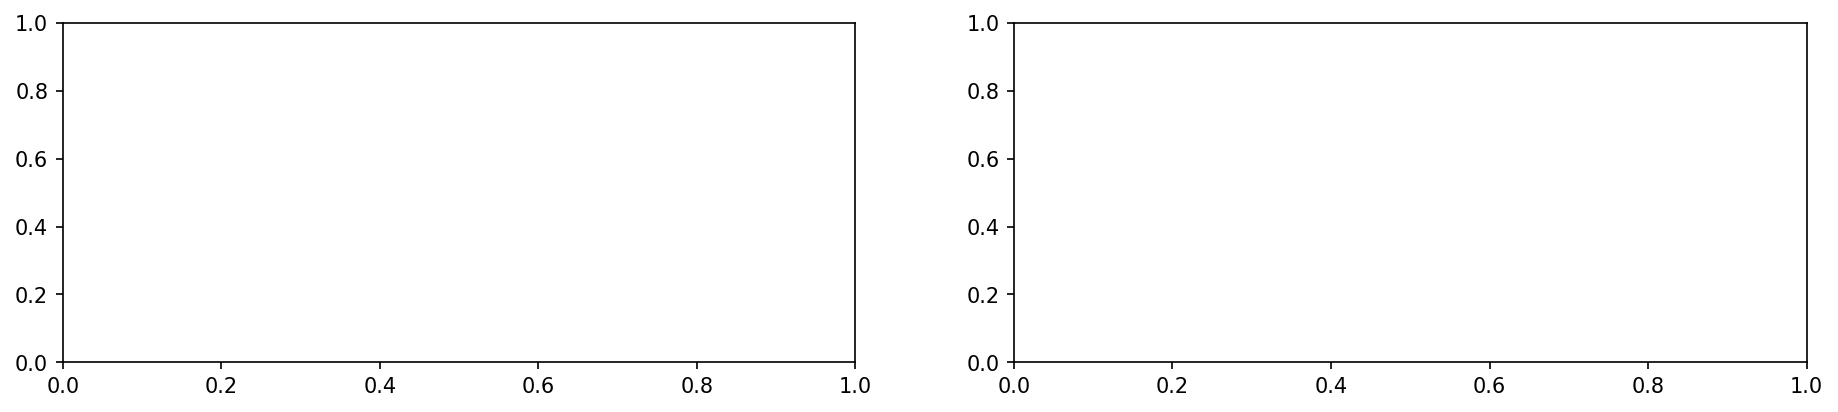

<Figure size 600x400 with 0 Axes>

In [30]:
s = '1'
Mc = '20'
gridlist = ['1024x1448x512','724x1024x362','512x724x256']
    
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=150)

for gridres in gridlist:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/%s/'%(Mc,s,gridres)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*Rij*")
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    # Plot Rij
    fig = plt.figure(dpi=100)
    dat = integrate_Rij(directory,flist,name='b12')
    ax[0].plot(dat[:,0],dat[:,1],'-*',label='{}'.format(gridres))
    
print('Done')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel(r'$t/\Delta U$')
